In [61]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from os import listdir
import os
from numpy import expand_dims
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt

# Loading FaceNet Pre Trained Model:


In [62]:
model = keras.models.load_model('facenet_keras.h5', compile=False)
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_2:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/Identity:0' shape=(None, 128) dtype=float32>]


# Face Detection(MTCNN):

In [63]:
#Face Detection Function
def face_extraction(filename, resolution=(160,160)):
    image=Image.open(filename)
    image=image.convert('RGB')
    pixels=asarray(image)
    #Load MTCNN
    detector=MTCNN()
    results=detector.detect_faces(pixels)
    x1,y1,width,height=results[0]['box']
    #print(results)
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(resolution)
    face_array = asarray(image)
    # Storing in targetfile
    #print(filename.split('/',1)[1].split('.',1)[0])
    '''if(filename.split('/',1)[0]=='Missing_data'):
        file = open("Missing_data/labels.txt", "a")
        file.write(filename.split('/',1)[1].split('.',1)[0]+'\n')
        file.close()'''
    return face_array

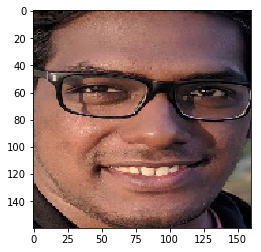

In [64]:
pixels=face_extraction('Missing_data/mohit.png')
plt.imshow(pixels)

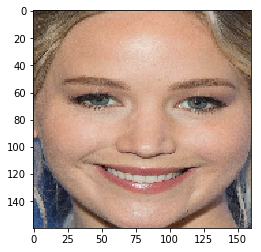

In [66]:
pixels2=face_extraction('Missing_data/jennifer_lawrence.jpg')
plt.imshow(pixels2)

# Using Face Net For Face Embedding

In [67]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [68]:
face_vector=get_embedding(model,pixels)
#print(face_vector)


# Comparing to faces

In [100]:
pixels1=face_extraction('Missing_data/brooklyn.jpg')
pixels2=face_extraction('Found_data/random14.jpg')
feat_vecs_a=get_embedding(model,pixels1)
feat_vecs_b=get_embedding(model,pixels2)


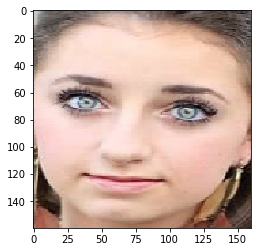

In [101]:
plt.imshow(pixels1)

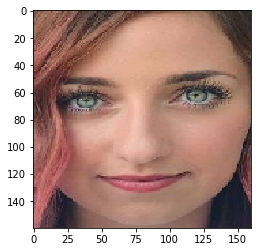

In [102]:
plt.imshow(pixels2)

Match Found


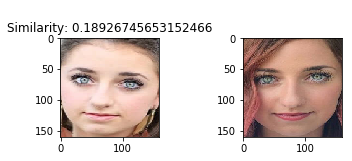

In [103]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
#similarity=findCosineSimilarity(feat_vecs_a,feat_vecs_b)
#print(similarity)

for image in os.listdir('Missing_data/'):
    pixels1=face_extraction(os.path.join('Missing_data/',image))
    feat_vecs_a=get_embedding(model,pixels1)
    similarity=findCosineSimilarity(feat_vecs_a,feat_vecs_b)
    #print("Similarity: ",similarity)
    if similarity<0.35:
        fig = plt.figure()
        print("Match Found")
        ax1 = fig.add_subplot(2,2,1)
        ax1.imshow(pixels1)
        ax1.set_title("\nSimilarity: "+str(similarity))
        i+=1
        ax2 = fig.add_subplot(2,2,2)
        ax2.imshow(pixels2)
        break
    else:
        print("No Match Found")
        